In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import requests
import base64
import datetime
import json
from urllib.parse import urlencode
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import pickle
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import transformers
cid = '7352f63437534461923575d18956623a'
secret = '8c27ec554e9a4cf2a41fa8221f7a4372'
username = 'docpetersondc?si=1e39bfc9d14a4b1c'
scope = 'user-top-read' #check the documentation
authorization_url = 'https://accounts.spotify.com/authorize'
redirect ='http://localhost:8080'


In [4]:
class SpotifyAPI(object):
    access_token = None
    client_id = None
    secret = None
    access_token_did_expire = True 
    access_token_expires = datetime.datetime.now()
    token_url = 'https://accounts.spotify.com/api/token'
    def __init__(self, client_id, secret, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.client_id = client_id
        self.secret = secret 
    def get_client_credentials(self):
        """
        Return a base64 encoded string
        """
        client_id = self.client_id
        secret = self.secret
        cred =  f'{client_id}:{secret}'
        client_creds_64 = base64.b64encode(cred.encode())
        return client_creds_64.decode()
    
    def get_token_header(self):
        client_creds_64 = self.get_client_credentials()
        return  {'Authorization': f'Basic {client_creds_64}'}
    def get_token_data(self):
        return { "grant_type": 'client_credentials'}
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        header = self.get_token_header()
        r = requests.post(token_url, data=token_data,headers=header)
        if r.status_code not in range(200,299):
            return False
        data = r.json()
        now = datetime.datetime.now()
        expires_in = data['expires_in']
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token_expires = expires 
        self.access_token = data['access_token']
        self.access_token_did_expire = expires < now 
        return True
    def search_artists_by_genre(self,genre):
        header = {
        "Authorization" : f"Bearer {self.access_token}"
        }
        endpoint = "https://api.spotify.com/v1/search?"
        data = urlencode({"q": f"genre:{genre}", "type": "artist", "limit": 50, "offset": 50})
        lookup_url = f"{endpoint}{data}"
        r = requests.get(lookup_url, headers =header)
        return r.json()
    def create_dataframe(self,json_data,genre):
        names_Ids = []
        index = json_data['artists']['items']
        for x in range(0,50):
            ids = index[x]['id']
            name = index[x]['name']
            genres = index[x]['genres']
            p = 0
            if genre == "metal":
                for g in genres:
                    if ("pop" in g) | ("funk" in g) | ("canadian" in g) | ("glam" in g):
                        p = 1
            if (p == 0):
                names_Ids.append([name,ids, genre])
        return pd.DataFrame(names_Ids, columns=['Artist','ArtistID','Genre'])
    def get_albums(self, art_id):
        header = {
        "Authorization" : f"Bearer {self.access_token}"
        }
        endpoint = f"https://api.spotify.com/v1/artists/{art_id}/albums?"
        data = urlencode({"market": "US", "limit": 20, "include_groups":"album"})
        lookup_url = f"{endpoint}{data}"
        r = requests.get(lookup_url, headers =header)
        return r.json()
    def get_album_names(self, album_ids):
        header = {
        "Authorization" : f"Bearer {self.access_token}"
        }
        endpoint = f"https://api.spotify.com/v1/albums?"
        chk = album_ids.replace(",",'%2C')
        data = f"ids={chk}&market=US"
        lookup_url = f"{endpoint}{data}"
        r = requests.get(lookup_url, headers =header)
        return r.json()
        
        

In [3]:
def add_albumCover_albumIds(df_temp):
    for x,y in df_temp.iterrows():
        albums = client.get_albums(y['ArtistID'])
        album_covers = []
        id_list = []
        name_list = []
        #print(y['ArtistID'])
        for x in range(0,len(albums['items'])):
            #print(x)
            ll = albums['items'][x]['images']
            ids = albums['items'][x]['id']
            name = albums['items'][x]['name'].lower()
            if ('deluxe' in name) | ('edition' in name):
                continue
            else:
                if (name in name_list):
                    continue
                else:
                    id_list.append(ids)
                    name_list.append(name)
                    album_covers.append(ll[1]['url'])
                    album_joined = ",".join(album_covers)
                    id_joined = ",".join(id_list)
                    df_temp.loc[df_temp['ArtistID'] == y['ArtistID'], 'Album_Covers'] = album_joined
                    df_temp.loc[df_temp['ArtistID'] == y['ArtistID'], 'Album_Ids'] = id_joined
    return df_temp

In [1112]:
client = SpotifyAPI(cid,secret)

In [1113]:
client.perform_auth()
access_token = client.access_token

In [392]:
# artist = client.search_artists_by_genre('r-n-b')
# df_temp = client.create_dataframe(artist,'r-n-b')

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import cv2

In [46]:
def image_to_feature_vector(image, size=(224, 224)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size)

In [69]:
X1 = np.load('./X_train_GIANT.npy', allow_pickle=True)
#y = np.load('./y_train.npy',allow_pickle=True)

In [71]:
pray = []
for image in X1:
    add = image_to_feature_vector(image)
    pray.append(add)

In [72]:
X = np.array(pray)

In [74]:
np.save('./X_TRAIN_RESIZE.npy', X)

In [75]:
X.shape

(14291, 224, 224, 3)

In [37]:
df = pd.read_csv('./FINALLY.csv')

In [45]:
for x,y in df.head(2).iterrows():
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    imagePath = y['Album_Covers'].split(",")[0]
    image = io.imread(imagePath)
    label = list_of_genres.index(y['Genre'])
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)

In [41]:
df.iloc[0]['Album_Covers'].split(",")[0]

'https://i.scdn.co/image/ab67616d00001e02f1a378f8bcaa4be358f02ca2'

In [44]:
df

,Artist,ArtistID,Genre,Album_Covers,Album_Ids
0,Linkin Park,6XyY86QOPPrYVGvF9ch6wz,metal,https://i.scdn.co/image/ab67616d00001e02f1a378...,"28DUZ0itKISf2sr6hlseMy,0zcNtUZ2oEpRmiDuWBFvcX,..."
1,Metallica,2ye2Wgw4gimLv2eAKyk1NB,metal,https://i.scdn.co/image/ab67616d00001e02c1a132...,"7h5xn0Olvx2p0eQcSt1Osy,3dck2tBxGfxj9m3CguDgjb,..."
2,The Amity Affliction,6kNKUYGn6VNGsRoXmyoDPK,metal,https://i.scdn.co/image/ab67616d00001e026b0927...,"0e4UoB6RvG4UyAnsyuKD4m,2hNoEiyzGKvV0Ok0RDJI0W,..."
3,Slipknot,05fG473iIaoy82BF1aGhL8,metal,https://i.scdn.co/image/ab67616d00001e0226f20b...,"754RY5WpZ2LTUZsk8kDBju,6fXgJq5H8oVeyfSalFrLed,..."
4,Bring Me The Horizon,1Ffb6ejR6Fe5IamqA5oRUF,metal,https://i.scdn.co/image/ab67616d00001e025149c9...,"0e1WaSNDZnoPixaxDNdWo4,2CbaaiHPTuL24yajaKtH9k,..."
...,...,...,...,...,...
753,Flume,6nxWCVXbOlEVRexSbLsTer,indie,https://i.scdn.co/image/ab67616d00001e0259aaef...,"2Vx9FC6Um8i6kEtY7HNswB,0tstTxkR8uow4hBYgEgOAp,..."
754,Ari Lennox,1vaQ6v3pOFxAIrFoPrAcom,indie,https://i.scdn.co/image/ab67616d00001e02f1a1bd...,"3hejjJbFsinMBc1KBqF71w,59a2mrYYr9YRqYVeZLZ0iT,..."
755,Lemon Demon,4llAOeA6kEF4ytaB2fsmcW,indie,https://i.scdn.co/image/ab67616d00001e02ae3908...,"4ocal2JegUDVQdP6KN1roI,4Julje5zwF2IRlSqBOQ2oJ,..."
756,SALES,6vVztIuqdDHvYWxOEXCzjN,indie,https://i.scdn.co/image/ab67616d00001e02a525ef...,"7MEH4LcjNvaLRMh27yxABB,40ZFbOKV6MNWND6TkaUwWc,..."


In [43]:
list_of_genres = ['metal','country','rock','jazz','pop','r-n-b', 'rap', 'edm','hip-hop',
                 'indie']
list_df = []
# for genre in list_of_genres:
#     artist_data = client.search_artists_by_genre(genre)
#     df_temp = client.create_dataframe(artist_data,genre)
#     df = add_albumCover_albumIds(df_temp)
#     print(genre)
#     if (len(list_df) != 0):
#         DUPL = []
#         df_thus_far = pd.concat(list_df)
#         artist_ids = df_thus_far['ArtistID'].values
#         for new_ids in df['ArtistID'].values:
#             if new_ids in artist_ids:
#                 DUPL.append(df.loc[df['ArtistID'] == new_ids].index.values[0])
#         df.drop(DUPL,inplace=True)
#         df.reset_index(inplace=True,drop=True)
#     list_df.append(df)
    

In [3]:
df = pd.read_csv('./FINALLY.csv')

In [193]:
from urllib.request import urlopen
import io
from colorthief import ColorThief
liso = []
dominant_colors = []
palette_colors = []
for x,y in df.iterrows():
    covers = y['Album_Covers'].split(",")
    color_thief = ColorThief(f)
    for i in range(0,1):
        url = covers[i]
        fd = urlopen(url)
        f = io.BytesIO(fd.read())
        # get the dominant color
        dominant_color = color_thief.get_color(quality=2)
        palette = color_thief.get_palette(color_count=2)
        palette_colors.append(palette)
        dominant_colors.append(dominant_color)
    palList = []
    for pal in palette:
        for items in pal:
            #print(items)
            palList.append(items)
    domList = []
    for dom in dominant_color:
        domList.append(dom)
    palSum = np.sum(palList)
    domSum = np.sum(domList)
    encode = []
    vals = [y['Artist'],list_of_genres.index(y['Genre']), palSum, domSum] + domList + palList
    g = np.array(vals).reshape(1,-1)
    cols = ['artist','genre','palette_sum','dominant_sum','pr','pg','pb','dom0','dom1','dom2',
            'dom3','dom4','dom5','dom6','dom7','dom8']
    print(x)
    liso.append(pd.DataFrame(g,columns=cols))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [194]:
ll = pd.concat(liso)
ll.reset_index(inplace=True,drop=True)

In [199]:
# ll = pd.read_csv('./Second_Model_Data.csv',index=False)

In [236]:
X = ll.drop(columns=['artist','genre']).values.astype(int)
y = ll['genre'].values.astype(int)

In [237]:
ll

,artist,genre,palette_sum,dominant_sum,pr,pg,pb,dom0,dom1,dom2,dom3,dom4,dom5,dom6,dom7,dom8
0,Linkin Park,0,1030,529,205,165,159,30,19,22,209,169,164,138,140,139
1,Metallica,0,791,470,207,180,83,8,7,5,207,180,82,121,116,65
2,The Amity Affliction,0,496,28,4,12,12,5,13,13,53,88,96,76,76,76
3,Slipknot,0,1110,59,17,20,22,18,21,24,195,203,210,118,151,170
4,Bring Me The Horizon,0,1017,48,16,13,19,25,19,28,188,161,184,132,140,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,Flume,9,1102,81,29,36,16,30,37,17,236,227,195,137,158,65
754,Ari Lennox,9,757,343,139,128,76,162,139,82,27,67,77,149,43,11
755,Lemon Demon,9,1044,581,230,191,160,228,188,157,152,82,54,79,59,45
756,SALES,9,799,350,198,82,70,37,13,18,197,71,57,135,135,136


In [238]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

In [239]:
svc=SVC(probability=True, kernel='linear')

In [254]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.svm import LinearSVC
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)

ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [245]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.10964912280701754


In [246]:
X, y = datasets.load_iris(return_X_y=True)

In [16]:
# fig, axs = plt.subplots(5,5,figsize=(10,10), sharey=True)
# #rcParams.update({'figure.autolayout': True})
# figure(figsize=(20, 10), dpi=100)
# fig.suptitle('Color Palettes: Pt.1')
# axs[0,0].set_title('Metal')
# axs[0,1].set_title('Country')
# axs[0,2].set_title('Rock')
# axs[0,3].set_title('Jazz')
# axs[0,4].set_title('Pop')
# # axs[0,5].set_title('R&B')
# # axs[0,6].set_title('Rap')
# # axs[0,7].set_title('EDM')
# # axs[0,8].set_title('Hip-hop')
# # axs[0,9].set_title('Indie')
# for x in range(0,5):
#     axs[x,0].imshow([listo[x]],  aspect='auto') # metal 
#     axs[x,1].imshow([listo1[x]], aspect='auto') # country 
#     axs[x,2].imshow([listo2[x]], aspect='auto') # rock 
#     axs[x,3].imshow([listo3[x]], aspect='auto') # jazz 
#     axs[x,4].imshow([listo4[x]], aspect='auto') # pop 
# #     axs[x,5].imshow([listo5[x]], aspect='auto') # rnb 
# #     axs[x,6].imshow([listo6[x]], aspect='auto') # rap 
# #     axs[x,7].imshow([listo7[x]], aspect='auto') # edm 
# #     axs[x,8].imshow([listo8[x]], aspect='auto') # hip hop 
# #     axs[x,9].imshow([listo9[x]], aspect='auto') # indie 
# fig.subplots_adjust(wspace=0, hspace=0)    

In [400]:
#df_f = pd.read_csv('./Metal_bands.csv')
#df = pd.read_csv('./Semi_Final.csv')

In [17]:
# print(len(np.unique(df1['Genre'].values)))
# print(np.unique(df1['Genre'].values))
# print(list_of_genres)

In [4]:
df = pd.read_csv('./FINALLY.csv')

In [5]:
list_of_genres 

['metal',
 'country',
 'rock',
 'jazz',
 'pop',
 'r-n-b',
 'rap',
 'edm',
 'hip-hop',
 'indie']

In [11]:
def CreateMultiLabelDataframe(df):
    listo = []
    for x,y in df.iterrows():
        cr = df.iloc[x]
        genre = cr.Genre
        albums = cr.Album_Covers.split(',')
        ids = cr.ArtistID
        for album in albums:
            values = [cr.Artist, album]
            for item in list_of_genres:
                if genre == item:
                    values.append(1)
                else:
                    values.append(0)
            cols = ['artist','album'] + list_of_genres
            #print(values)
            temp = pd.DataFrame(np.array(values).reshape(1,-1), columns=cols)
            listo.append(temp)
    return pd.concat(listo)

In [12]:
tst = CreateMultiLabelDataframe(df)
tst.reset_index(inplace=True,drop=True)

In [29]:
tst.reset_index(inplace=True,drop=True)

In [30]:
tst

,artist,album,metal,country,rock,jazz,pop,r-n-b,rap,edm,hip-hop,indie
0,Linkin Park,https://i.scdn.co/image/ab67616d00001e02f1a378...,1,0,0,0,0,0,0,0,0,0
1,Linkin Park,https://i.scdn.co/image/ab67616d00001e02b829b6...,1,0,0,0,0,0,0,0,0,0
2,Linkin Park,https://i.scdn.co/image/ab67616d00001e02c0dde0...,1,0,0,0,0,0,0,0,0,0
3,Linkin Park,https://i.scdn.co/image/ab67616d00001e02145e1c...,1,0,0,0,0,0,0,0,0,0
4,Linkin Park,https://i.scdn.co/image/ab67616d00001e02ed8fef...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14286,RÜFÜS DU SOL,https://i.scdn.co/image/ab67616d00001e0268c906...,0,0,0,0,0,0,0,0,0,1
14287,RÜFÜS DU SOL,https://i.scdn.co/image/ab67616d00001e02e4884c...,0,0,0,0,0,0,0,0,0,1
14288,RÜFÜS DU SOL,https://i.scdn.co/image/ab67616d00001e021e1bdf...,0,0,0,0,0,0,0,0,0,1
14289,RÜFÜS DU SOL,https://i.scdn.co/image/ab67616d00001e02075b3d...,0,0,0,0,0,0,0,0,0,1


In [26]:
#tst
train_image = []
to_drop = []
for x,y in tqdm(tst.iterrows()):
    try:
        img = io.imread(y['album'])
    except:
        to_drop.append(x)
        continue
    if img.shape != (300, 300, 3):
        to_drop.append(x)
    else:
        train_image.append(img)

14716it [46:55,  5.23it/s]


In [27]:
len(train_image) 

14291

In [28]:
tst.drop(to_drop,inplace=True)

In [75]:
# Word frequency score 
# Raw color pallete 
# Most used colors 

True

In [31]:
X = np.array(train_image)

In [34]:
X.shape

(14291, 300, 300, 3)

In [36]:
y.shape

(14291, 10)

In [1105]:
# from matplotlib.pyplot import figure
# from matplotlib import rcParams
# plt.style.use('fivethirtyeight')
# rcParams.update({'figure.autolayout': True})
# plt.style.use('fivethirtyeight')
# figure(figsize=(20, 10), dpi=100)
# plt.bar(range(len(D)), list(D.values()), align='center')
# plt.xticks(range(len(D)), list(D.keys()))
# plt.ylabel("Count")
# plt.xlabel("Genres")
# plt.title("Movie Genre Counts (10 Total)")
# plt.show()

In [636]:
# adders = []
# for x in df_offset['ArtistID'].values:
#     if x not in df1['ArtistID'].values:
#         ind = df_offset[df_offset['ArtistID'] == x].index.values[0]
#         if (ind not in adders):
#             adders.append(ind)
# subs = df_offset.iloc[adders]
# subs.reset_index(inplace=True,drop=True)
# combined_df = pd.concat([df1,subs])
# combined_df[combined_df.duplicated(['ArtistID'])]

In [648]:
# combined_df.to_csv("./Check_this_oneForDuplcate_albums.csv",index=False)

In [1197]:
df

,Artist,ArtistID,Genre,Album_Covers,Album_Ids
0,Linkin Park,6XyY86QOPPrYVGvF9ch6wz,metal,https://i.scdn.co/image/ab67616d00001e02f1a378...,"28DUZ0itKISf2sr6hlseMy,0zcNtUZ2oEpRmiDuWBFvcX,..."
1,Metallica,2ye2Wgw4gimLv2eAKyk1NB,metal,https://i.scdn.co/image/ab67616d00001e02c1a132...,"7h5xn0Olvx2p0eQcSt1Osy,3dck2tBxGfxj9m3CguDgjb,..."
2,The Amity Affliction,6kNKUYGn6VNGsRoXmyoDPK,metal,https://i.scdn.co/image/ab67616d00001e026b0927...,"0e4UoB6RvG4UyAnsyuKD4m,2hNoEiyzGKvV0Ok0RDJI0W,..."
3,Slipknot,05fG473iIaoy82BF1aGhL8,metal,https://i.scdn.co/image/ab67616d00001e0226f20b...,"754RY5WpZ2LTUZsk8kDBju,6fXgJq5H8oVeyfSalFrLed,..."
4,Bring Me The Horizon,1Ffb6ejR6Fe5IamqA5oRUF,metal,https://i.scdn.co/image/ab67616d00001e025149c9...,"0e1WaSNDZnoPixaxDNdWo4,2CbaaiHPTuL24yajaKtH9k,..."
...,...,...,...,...,...
704,Fitz and The Tantrums,4AcHt3JxKy59IX7JNNlZn4,indie,https://i.scdn.co/image/ab67616d00001e025a6704...,"0NcUgJYxrZwbrccKZLbmqD,2gT6n40GB174isGMAWitQ0,..."
705,Ari Lennox,1vaQ6v3pOFxAIrFoPrAcom,indie,https://i.scdn.co/image/ab67616d00001e02f1a1bd...,"3hejjJbFsinMBc1KBqF71w,59a2mrYYr9YRqYVeZLZ0iT,..."
706,Lemon Demon,4llAOeA6kEF4ytaB2fsmcW,indie,https://i.scdn.co/image/ab67616d00001e02ae3908...,"4ocal2JegUDVQdP6KN1roI,4Julje5zwF2IRlSqBOQ2oJ,..."
707,SALES,6vVztIuqdDHvYWxOEXCzjN,indie,https://i.scdn.co/image/ab67616d00001e02a525ef...,"7MEH4LcjNvaLRMh27yxABB,40ZFbOKV6MNWND6TkaUwWc,..."


In [1199]:
df[df['Artist']=="Nirvana"]Q

,Artist,ArtistID,Genre,Album_Covers,Album_Ids
98,Nirvana,6olE6TJLqED3rqDCT0FyPh,rock,https://i.scdn.co/image/ab67616d00001e029aa37e...,"5eA0qtE7Yu29XiMlwoby2G,1tsNAUQqofHrnlezRK8D5R,..."


In [650]:
# dups = df[df.duplicated(['Artist'])]
# dups.reset_index(inplace=True,drop=True)
# # Get Duplicates and reason out which genre should stay 
# dupl_list = []
# for x,y in dups.iterrows():
#     temps = df[df['ArtistID'] == y['ArtistID']]['Genre'].values
#     dupl_list.append( [y['Artist'], temps[0], temps[1], y['Album_Covers']])

In [677]:
# # FUCK - pull in ALBUM NAME THEN REMOVE DUPLICATES 
# for x,y in dup_df.iterrows():
#     covers = y['cover'].split(",")
#     print( f"{y['artist']}: \n {y['genre']} and {y['genre_1']} " )
#     for i in range(0,3):
#         url = covers[i+2]
#         image = io.imread(url)
#         plt.imshow(image)
#         plt.show()

In [1096]:
# DIS ONE
ta = pd.read_csv("./Finals_with_duplicate_album_covers_removed.csv")

In [988]:
album_ids = df.iloc[0]['Album_Ids']

In [1126]:
# GET ALBUM NAMES
for x,y in ta.iterrows():
    tst = client.get_album_names(str(y['Album_Ids']))
    names = []
    if len(tst['albums']) == 1:
        continue
    for ind in range(0,len(tst['albums'])):
        s = tst['albums'][ind]['name'].lower().strip()
        if ("(" in s ):
            name = s.replace(s[s.find("(")+1:s.find(")")],"").replace("()","").strip()
            if name not in names:
                names.append(name)
        else:
            if s not in names:
                names.append(s)
    id_joined = ",".join(names)
    ta.loc[ta['ArtistID'] == y['ArtistID'], 'Album_names'] = id_joined

In [1169]:
list_of_genres

['metal',
 'country',
 'rock',
 'jazz',
 'pop',
 'r-n-b',
 'rap',
 'edm',
 'hip-hop',
 'indie']

In [1191]:
albs = ta[ta['Genre']=='rap']['Album_names'].values

In [1194]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for vals in albs:
    ss = vals.split(",")
    for val in ss:
        val = str(val)
        tokens = val.split()
        #print(tokens)
        if 'live' in tokens:
            tokens.pop(tokens.index("live"))
#         if 'music' in tokens:
#             tokens.pop(tokens.index("music"))
        #print(tokens)
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
            comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 

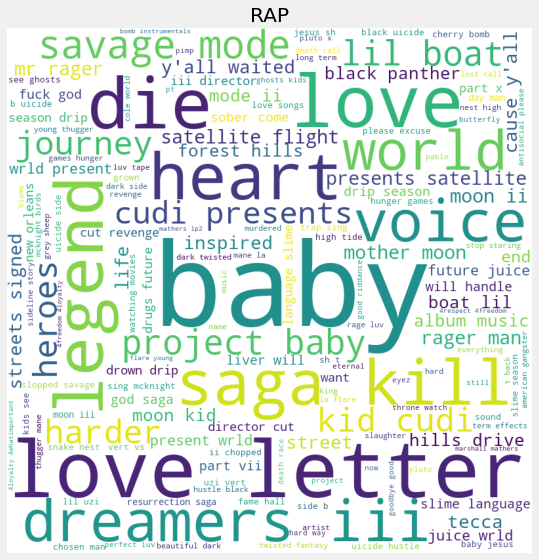

In [1196]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("RAP")
plt.show()

In [7]:
from spacy.lang.en import English
en = English()
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy 
STOPLIST = spacy.lang.en.stop_words.STOP_WORDS
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "_ _","--","...", "”", "”"]


class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

In [13]:
artistsDF = pd.read_csv('./Archive/artists-data.csv')
artistsDF = artistsDF.drop_duplicates(subset = 'Link', keep ='first')

In [14]:
lyricsDF = pd.read_csv('./Archive/lyrics-data.csv')
lyricsDF.rename(columns={'ALink':'Link'}, inplace=True)

In [15]:
artistLyricsDF = pd.merge(lyricsDF,artistsDF, on='Link')

In [16]:
aldf = artistLyricsDF[['Artist', 'SName', 'Genre','Lyric', 'Popularity','Idiom']]
finalDF = aldf[aldf.Lyric.notnull()]

artists = finalDF['Artist'].unique()
genres = finalDF['Genre'].unique()

In [17]:
englishDF = finalDF[finalDF['Idiom'] == 'ENGLISH']
genreLabels = []

for x in englishDF['Genre'].tolist():
    if x == 'Rock':
        y = True
    else:
        y = False
    genreLabels.append(y)

is_rock = np.array(genreLabels)

In [19]:
# englishArtists = englishDF['Artist'].unique()
# englishGenres = englishDF['Genre'].unique()

# df = pd.DataFrame(columns=('artist', 'words', 'songcount'))
# j=0

# tokens =[]
# for artist in englishArtists:
#     num_words = 0
#     lyrics = englishDF['Lyric'][englishDF['Artist'] == artist]
#     #print("\nArtist %s" %artist, "Num Lyrics %s" %len(lyrics))
#     for lyric in lyrics:
#         #print("\nArtist %s" %artist,"Lyric:\n" , lyric)
#         words = simple_tokenizer(lyric)
#         tokens.append(words)
#         num_words = num_words + len(words)
#     df.loc[j] = (artist, num_words, len(lyrics))
#     j+=1
#     i=0

In [ ]:
sort_df = df.sort_values('words',ascending=False)
sort_df = sort_df.iloc[0:9,]


plt.figure(figsize=(10,5))
sns.barplot(sort_df.artist, (sort_df.words/sort_df.songcount), alpha=0.8)
plt.title('Top 10 Artists by Words/Song')
plt.ylabel('Number of Words', fontsize=12)
plt.xlabel('Artist', fontsize=12)
plt.show()

In [ ]:
cv = CountVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)
tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)

# get vectors
count_vecs = cv.fit_transform(englishDF['Lyric']).toarray()
lyric_features = tfidf.fit_transform(englishDF['Lyric']).toarray()

In [20]:
from sklearn.model_selection import train_test_split

englishDF = finalDF[finalDF['Idiom'] == 'ENGLISH']

genreLabels = []

for x in englishDF['Genre'].tolist():
    if x == 'Rock':
        y = 1
    else:
        y = 0
    genreLabels.append(y)

is_rock = np.array(genreLabels)


lyrics_train, lyrics_test, genre_train, genre_test = train_test_split(englishDF,is_rock, random_state=42, 
                                             test_size=0.3, shuffle=False)


lyrics_train, lyrics_val, genre_train, genre_val = train_test_split(lyrics_train, genre_train, random_state=42,
                                             test_size=0.2, shuffle=False)

In [21]:
def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

In [22]:
parsed_train = [simple_tokenizer(str(d)) for d in lyrics_train['Lyric']]
parsed_val = [simple_tokenizer(str(d)) for d in lyrics_val['Lyric']]
parsed_test = [simple_tokenizer(str(d)) for d in lyrics_test['Lyric']]

In [29]:
import en_core_web_md
nlp = en_core_web_md.load()
# construct glove weight matrix
# construct vocab
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=(1,1), min_df=0.01, max_df=0.9)
cv.fit(parsed_train)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector


# additional formatting
idx_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(idx_train)
idx_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(idx_val)
idx_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(idx_test)

Size of vocab: 843


In [30]:
svc = LinearSVC(random_state=92, tol=1, max_iter=100000)
svc.fit(cv.transform(parsed_train), genre_train)
base_accuracy = accuracy_score(genre_test,
                               svc.predict(cv.transform(parsed_test)))
print(base_accuracy)

0.1147316538882804


In [36]:
glove_vecs.shape

(845, 300)

In [37]:
glove_vecs

array([[ 0.2341    ,  0.12944101, -0.1219345 , ...,  0.10197   ,
         0.15379399, -0.1091955 ],
       [ 0.0230525 , -0.14356899,  0.07234499, ...,  0.12953   ,
        -0.035941  , -0.39529499],
       [-0.28806001,  0.13493   , -0.12834001, ..., -0.0053274 ,
         0.17071   , -0.093261  ],
       ...,
       [ 0.23207   ,  0.33862001,  0.020418  , ..., -0.083207  ,
        -0.22519   ,  0.099738  ],
       [-0.10545   , -0.10751   , -0.62427998, ...,  0.1116    ,
        -0.012046  , -0.035743  ],
       [-0.087325  ,  0.053946  , -0.47011   , ..., -0.17508   ,
        -0.45831999, -0.31343001]])